<a href="https://colab.research.google.com/github/alcalderagl/self_driving_car/blob/main/ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="https://github.com/alcalderagl/self_driving_car/blob/main/images/logo.png?raw=1" alt="TEC DE MONTERREY" width="500"/>

**CONV. NEURAL NETWORKS**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

# Import libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import kagglehub


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# GPU on

In [4]:
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


# Import dataset

In [5]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print(path)

/kaggle/input/gtsrb-german-traffic-sign


# Load dataset

In [6]:
train_df = pd.read_csv(path + "/Train.csv")
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Width,39209.0,50.835880,24.306933,25.0,35.0,43.0,58.0,243.0
Height,39209.0,50.328930,23.115423,25.0,35.0,43.0,58.0,225.0
Roi.X1,39209.0,5.999515,1.475493,0.0,5.0,6.0,6.0,20.0
Roi.Y1,39209.0,5.962381,1.385440,5.0,5.0,6.0,6.0,20.0
Roi.X2,39209.0,45.197302,23.060157,20.0,29.0,38.0,53.0,223.0
Roi.Y2,39209.0,44.728379,21.971145,20.0,30.0,38.0,52.0,205.0
ClassId,39209.0,15.788390,12.013238,0.0,5.0,12.0,25.0,42.0


# Plot class distribution

<Axes: xlabel='ClassId'>

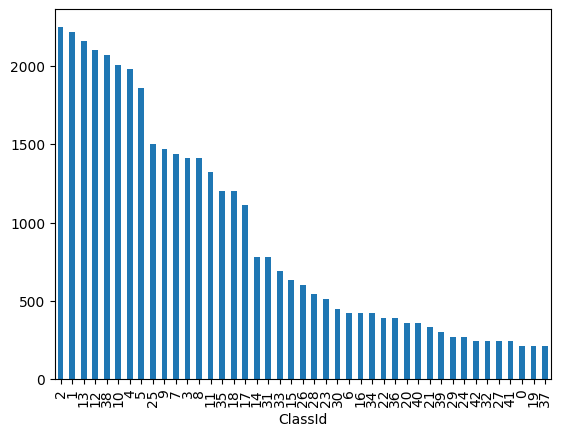

In [12]:
train_df['ClassId'].value_counts().plot(kind="bar")

# Get classes

In [25]:
classes = train_df['ClassId'].unique()
print(classes)

[20  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


# Plot class images

In [26]:
samples = train_df.groupby('ClassId').first().reset_index()
n_samples = len(samples)
print(n_samples)
# for _, row in samples.iterrows():
#   print(row)

43
